In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [4]:
mesh = fp.Grid2D(Lx=50., Ly=50., dx=2., dy=2.)

In [5]:
C = fp.CellVariable(mesh=mesh, name="C", hasOld=True)

In [6]:
Calpha = 0.05
Cbeta = 0.95
Cm = (Calpha + Cbeta) / 2.
A = 2.0
B = A / (Calpha - Cm)**2
D = Dalpha = Dbeta = 2 / (Cbeta - Calpha)
kappa = 2.0

In [7]:
f0 = -(A/2)*(C - Cm)**2 + (B/4)*(C - Cm)**4 + (Calpha/4)*(C - Calpha)**4 + (Cbeta/4)*(C - Cbeta)**4

In [8]:
f = f0 + (kappa/2.)*(C.grad.mag)**2
f.name = "f"

In [9]:
Cf = C.arithmeticFaceValue
eq = (fp.TransientTerm(coeff=1.)
      == fp.DiffusionTerm(coeff=D*(-A + 3*B*(Cf - Cm)**2 + 3*Calpha*(Cf - Calpha)**2 + 3*Cbeta*(Cf - Cbeta)**2))
      - fp.DiffusionTerm(coeff=(D,kappa)))

In [10]:
def directTaylorError(var):
    """Calculate the Direct Taylor Series Error Estimate
    
    Based on
    Hrvoje Jasak, "Error Analysis and Estimation for the Finite Volume Method with
    Applications to Fluid Flows", PhD Thesis, Imperial College, London (1996)
    """

    cellFaceAreaProjections = fp.FaceVariable(mesh=var.mesh, 
                                              value=(var.mesh._orientedAreaProjections 
                                                     * var.mesh.faceNormals), 
                                              rank=1)
    M = fp.CellVariable(mesh=var.mesh, 
                        value=(2 * var.mesh.cellVolumes 
                               / cellFaceAreaProjections[..., var.mesh.cellFaceIDs].sum(axis=-2)))
        
    gradGrad = var.grad.grad
        
    err = 0.
    for dim in range(var.mesh.dim):
        Mdim = fp.CellVariable(mesh=var.mesh, value=0., rank=1)
        Mdim[dim] = M[dim]
        err += Mdim.dot(Mdim.dot(gradGrad))
    err = abs(err) / 24.
    err.name = r"$\Delta$ " + var.name + r" ${}_{Taylor}$"
    
    return err

In [11]:
err = directTaylorError(C)

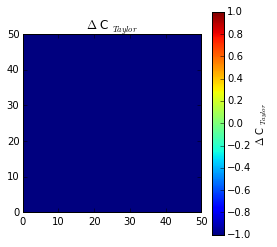

In [12]:
viewer = fp.MatplotlibViewer(vars=err)

In [13]:
epsilon = 0.01
q = [[nmx.sqrt(2.)], [nmx.sqrt(3.)]]
C.value = 0.45 + epsilon * nmx.cos(nmx.dot(q, mesh.cellCenters))

In [14]:
dt = 0.01
elapsed = 0.
saved = elapsed
duration = 10000.
step = 0

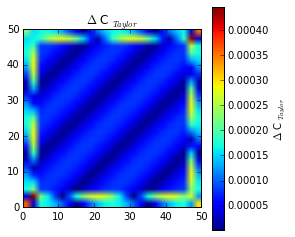

In [15]:
viewer.plot()

In [16]:
import os

In [18]:
direc = "1a-coarse-2"

In [19]:
os.mkdir(direc)

OSError: [Errno 17] File exists: '1a-coarse-2'

In [20]:
!rm 1a-coarse-2/*

In [21]:
fp.tools.dump.write(mesh, filename=os.path.join(direc, "mesh.dmp"))

In [22]:
fp.TSVViewer(vars=C).plot(filename=os.path.join(direc, "{step}.gz".format(step=0)))

In [23]:
with open(os.path.join(direc, "stats.txt"), 'w') as stats:
    stats.write("\t".join(["step", "t", "dt", "Cmin", "Cmax", "f", "error"]) + "\n")

In [185]:
res = -1
errmag = nmx.L2norm(err) / mesh.numberOfCells
print -1, -1, res, errmag

-1 -1 -1 1.11182904246e-05


In [24]:
while elapsed < duration:
    C.updateOld()
    for sweep in range(6):
        # viewer.plot()
        res = eq.sweep(C, dt=dt) #, solver=fp.LinearLUSolver())
        errmag = nmx.LINFnorm(err) / mesh.numberOfCells
        # print step, sweep, dt, res, errmag
    if res < 0.1: # errmag < 1e-4: # 
        step += 1
        elapsed += dt
        dt *= 1.1
        # dt = min(dt, 2.)
        # viewer.plot()
        if elapsed - saved > 1:
            fp.TSVViewer(vars=C).plot(filename=os.path.join(direc, "{step}.gz".format(step=step)))
            saved = elapsed
        with open(os.path.join(direc, "stats.txt"), 'a') as stats:
            stats.write("\t".join([str(it) for it in [step, elapsed, dt, min(C), max(C), 
                                                      f.cellVolumeAverage * mesh.cellVolumes.sum(),
                                                      errmag]]) + "\n")
    else:
        dt *= 0.8 # 1e-4 / errmag
        C.value = C.old.value